<a href="https://colab.research.google.com/github/lphohmann/DL_microbial_gene_classifier/blob/main/2D_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To do:
- add 1 initital layer to increase from 1 to 3 channels or change input data to 3 channels
- solve error arising due to datalaoders changing tensor typre by casting the input to float type by doing
input=input.float() before calling the forward pass. Alt. idea: use model hook or callback that is executed before the forward pass?

# Setting everything up

In [1]:
%%capture
!pip install fastai --upgrade
#!pip install -Uqq fastbook --upgrade
#!pip install torchtext==0.8.1

In [2]:
import numpy as np

In [3]:
#hide
#import fastbook
#fastbook.setup_book()

In [4]:
#hide
#import fastai
from fastai import *
from fastai.vision.all import *
#from fastai.text.all import *
#from fastai.callback import *

In [5]:
# mount google drive to access files and set the correct working
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd drive/MyDrive/ColabNotebooks/DL_project/
!pwd

Mounted at /content/drive
/content/drive/MyDrive/ColabNotebooks/DL_project
/content/drive/MyDrive/ColabNotebooks/DL_project


# Define functions required for creating the Datablock

In [6]:
# get the training and validation datasets

In [7]:
# defining functions required for building the DataBlock
# one hot encoding function
from sklearn.preprocessing import OneHotEncoder
def OH_enc(seq: str):
    # get the categories into array
    cats = ['K', 'D', 'N', 'E', 'R', 'A', 'T', 'L', 'I', 'Q', 'C', 'F', 'G', 'W', 'M', 'S', 'H', 'P', 'V', 'Y']
    cat_array = np.array(sorted(cats), ndmin=1) #
    # get seq into array
    trunc_seq = seq[:300] # truncate sequences longer than 300 
    seq_array = np.array(list(trunc_seq))
    #one hot encode the sequence
    onehot_encoder = OneHotEncoder(categories=[cat_array],sparse=False,handle_unknown='ignore')
    onehot_encoded_seq = onehot_encoder.fit_transform(seq_array.reshape(len(seq_array), 1))
    return np.transpose(onehot_encoded_seq)

# zero padding function
def pad_along_axis(array: np.ndarray, target_length: int, axis: int = 0):
    pad_size = target_length - array.shape[axis]
    if pad_size <= 0:
        return array
    npad = [(0, 0)] * array.ndim
    npad[axis] = (0, pad_size)
    return np.pad(array, pad_width=npad, mode='constant', constant_values=0)

# combine in one function
def main_item_tfms(seq): # added -> None because the tensor shape later is 1,2820 and i think it should be 20,2820
    enc_seq = OH_enc(seq)
    pad_encseq_array = pad_along_axis(enc_seq,300,1)
    return pad_encseq_array 

In [8]:
# get_x and y by specifying column in dataframe
def get_y(r): return r['Knum']
def get_x(r): 
    #return np.expand_dims(main_item_tfms(r['Seq']),0) # apply the one hot encoding + padding function and add a dimension at 0 leading to shape ([256, 1, 20, 300])
    return np.broadcast_to(np.expand_dims(main_item_tfms(r['Seq']),0), (3, 20, 300)).copy() # apply the one hot encoding + padding function and add a 3 dimensions at 0 leading to shape ([256, 3, 20, 300])

In [9]:
# read in my data from which training and validation set will be created
trainval = pd.read_csv('trainval.csv', low_memory=False)

In [10]:
# CategoryBlock -> typetfm: categorize, batchtfm: CUDA, itemtfm: totensor
def CategoryBlock(vocab=None, sort=True, add_na=False):
    "`TransformBlock` for single-label categorical targets"
    return TransformBlock(type_tfms=Categorize(vocab=vocab, sort=sort, add_na=add_na))

In [11]:
# alternative DataBlock try
# building the datablock
dblock = DataBlock(blocks=(TransformBlock(batch_tfms=IntToFloatTensor), CategoryBlock(vocab=['K00024', 'K00121', 'K00122', 'K00123', 'K00124', 'K00126',
       'K00127', 'K00148', 'K00169', 'K00170', 'K00171', 'K00172',
       'K00194', 'K00196', 'K00197', 'K00198', 'K00200', 'K00201',
       'K00202', 'K00317', 'K00320', 'K00441', 'K00600', 'K00625',
       'K00672', 'K00830', 'K00925', 'K01007', 'K01070', 'K01499',
       'K01595', 'K01895', 'K03388', 'K03389', 'K03390', 'K05979',
       'K06034', 'K08097', 'K08691', 'K08692', 'K09733', 'K10713',
       'K10714', 'K11212', 'K11261', 'K11779', 'K11780', 'K12234',
       'K13039', 'K13788', 'K14067', 'K14080', 'K14083', 'K14940',
       'K14941', 'K15228', 'K15229', 'K18277'])),
                 splitter = TrainTestSplitter(test_size=0.2, random_state=42, stratify=trainval[['Knum']]),
                 get_x = get_x,
                 get_y = get_y
                 )

In [12]:
#dblock.summary(trainval)

# Create the dataloader

In [13]:
# create dataloaders from datablock 
dls = dblock.dataloaders(trainval, bs=256, shuffle=True, drop_last=True) # shuffle the data to prevent overfitting due to an organized dataset and drop the last incomplete batch

In [14]:
# visualize batch label distribution, compare with hist after balance correction
x,y = dls.one_batch()
import matplotlib.pyplot as plt
#plt.hist(y,bins=dls.c) # if run with gpu there is a type error

In [15]:
# access the dataset from datablock
dsets = dblock.datasets(trainval)
#dsets.train
#dsets.valid

In [16]:
from collections import Counter
label_count = Counter(dsets.train.items.Knum)
#label_count.most_common() # check the distribution of seqs per label

In [17]:
# 1. calc weights for each label class
class_weights = {} # empty dict to be filled with the class weights
for label in label_count:
    class_weights[label] = 1/label_count[label] # for every category the weight is (1 / number of associated sequences)
wgts = dsets.train.items.Knum.map(class_weights).values #[:len(dsets.train)] 

# check in which order /type weights have to be for the weighted dataloader --> can also check later if it works by looking at batch composition

# my case
weighted_dls = dblock.dataloaders(trainval,bs=256, dl_type=WeightedDL, wgts=wgts, shuffle=True, drop_last=True) 
dls.train = weighted_dls.train # replace the train dl with a weighted dl -> comment out before and after histogram visualizing to get comparison

In [18]:
# check vocab of the dls 
#dls.vocab
dls.c

58

In [19]:
# check one batch to make sure the dls is constructed right
x,y = dls.one_batch()
#y # these should be the targets 
#x # and these the encoded sequences

In [20]:
# check the shape
x.shape #torch.Size([256, 1, 20, 300]) or torch.Size([256, 3, 20, 300]) depending on which get_x I used (depends on if i get the Resnet to work with 1 input channel)

torch.Size([256, 3, 20, 300])

In [21]:
# check the label distribution in the batch to see if balancing was successful (note:maybe do a before and after weighing the dataloader)
#import matplotlib.pyplot as plt
#plt.hist(y,bins=dls.c)

In [22]:
# this cell leads to an error later when training: 
# cell exists to fix the error: RuntimeError: Input type (torch.cuda.DoubleTensor) and weight type (torch.cuda.FloatTensor) should be the same
# alt idea: use Model hooks or a callback that changes the input before the forward pass
# callback timepoint: before_fit
'''# monkey patch to solve error arising from dls changeing tensor type 
def _conv_forward(self, input, weight):
    input= input.type(torch.FloatTensor).cuda() # added this line to change the tensor type # THIS IS THE PROBLEM LATER!!
    #input= input.cuda()
    if self.padding_mode != 'zeros':
        return F.conv2d(F.pad(input, self._reversed_padding_repeated_twice, mode=self.padding_mode),
                        weight, self.bias, self.stride,
                        _pair(0), self.dilation, self.groups)
    return F.conv2d(input, weight, self.bias, self.stride,
                    self.padding, self.dilation, self.groups)

# replace in the module
nn.Conv2d._conv_forward = _conv_forward'''

"# monkey patch to solve error arising from dls changeing tensor type \ndef _conv_forward(self, input, weight):\n    input= input.type(torch.FloatTensor).cuda() # added this line to change the tensor type # THIS IS THE PROBLEM LATER!!\n    #input= input.cuda()\n    if self.padding_mode != 'zeros':\n        return F.conv2d(F.pad(input, self._reversed_padding_repeated_twice, mode=self.padding_mode),\n                        weight, self.bias, self.stride,\n                        _pair(0), self.dilation, self.groups)\n    return F.conv2d(input, weight, self.bias, self.stride,\n                    self.padding, self.dilation, self.groups)\n\n# replace in the module\nnn.Conv2d._conv_forward = _conv_forward"

# Prebuilt ResNet from pytorch: Architecture and learner

In [27]:
# callback to fix RuntimeError: Input type (torch.cuda.DoubleTensor) and weight type (torch.cuda.FloatTensor) should be the same
def cb(self): 
    new_xb = [x.type(torch.FloatTensor).cuda() for x in self.learn.xb]
    self.learn.xb = new_xb
    return self.learn.xb
t_type = Callback(before_batch=cb)

In [28]:
# callback to save the model during training
smc = SaveModelCallback(monitor="error_rate", fname="2D_ResNet50", comp=np.less, with_opt=True) # with_opt=True

In [ ]:
# callback to stop training when the model doesnt improve anymore
estop = EarlyStoppingCallback(monitor="error_rate", min_delta=0.001, comp=np.less, patience=5)

In [29]:
# the model architecture
model = resnet50

In [30]:
# try just like this with cnn_learner
learn = cnn_learner(dls, resnet50, metrics=error_rate, pretrained=False, cbs=[t_type,smc]) # add the callbacks

In [31]:
# check if the callbacks are added
learn.cbs

(#5) [TrainEvalCallback,Recorder,ProgressCallback,Callback,SaveModelCallback]

In [ ]:
# check architecture
#learn.model

SuggestedLRs(valley=tensor(0.0007))

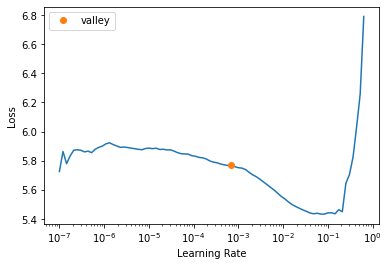

In [82]:
# choose an adequate lr
learn.lr_find() # suggest_funcs=(minimum, steep, valley, slide)

In [46]:
# train 
epochs=3
lr=0.0007 # based on valley in lr_find 
learn = learn.fit_one_cycle(epochs, lr)

epoch,train_loss,valid_loss,error_rate,time
0,0.319508,0.550956,0.142620,16:31
1,0.058364,0.134808,0.035851,16:23


Better model found at epoch 0 with error_rate value: 0.1426202803850174.
Better model found at epoch 1 with error_rate value: 0.03585059195756912.


epoch,train_loss,valid_loss,error_rate,time
0,0.319508,0.550956,0.142620,16:31
1,0.058364,0.134808,0.035851,16:23
2,0.021453,0.076114,0.020167,16:24


Better model found at epoch 2 with error_rate value: 0.020167261362075806.


In [32]:
# load the model (is it possible to continue training?)
learn.load('2D_ResNet50') 
# model summary print out
# do lr_find again before continuing training

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [ ]:
# confusion matrix -> given an error, not enough RAM on colab. 
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
# doesnt work as after simply training (and not reloading learn) -> AttributeError: 'NoneType' object has no attribute 'export'
# save the architecture and the parameters
# learn.export()

In [ ]:
# load the model not for training but for making predictions (inference)
learn_inf = load_learner(path/'modelname.pkl')

In [ ]:
# make prediction
learn_inf.predict('images/grizzly.jpg') # image as example
'''returned three things: the predicted category in the same format you originally provided 
(in this case, that’s a string), the index of the predicted category, and the probabilities of each category
The last two are based on the order of categories in the vocab of the DataLoaders '''
# check vocab
learn_inf.dls.vocab

In [40]:
# This cell is to find a way for the Resnet to accept 1 channel input, it is maybe not needed if I simply change my input data instead

'''# Note: DONT LIKE THIS AS IT OVERWRITES THE FORWARD function and doesnt allow me to use cnn_learner
# define a custom resnet and change the first layer to adapt for your input shape:
#import torch.nn as nn
class MyResNet(nn.Module):

    def __init__(self, in_channels=1):
        super(MyResNet, self).__init__()

        # bring resnet
        #self.model = torchvision.models.resnet50()
        self.model = resnet50

        # original definition of the first layer on the resnet class --> CHECK THIS AGAIN
        # self.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # my case
        self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

    def forward(self, x):
        return self.model(x)
my_resnet50 = MyResNet()

# try just like this with cnn_learner
learn2 = Learner(dls, my_resnet50, metrics=error_rate) 
# check architecture
learn2.model'''

# Architechture for a 2D ResNet

In [ ]:
class ConvLayer(nn.Sequential):
    "Create a sequence of convolutional (`ni` to `nf`), ReLU (if `use_activ`) and `norm_type` layers."
    @delegates(nn.Conv2d)
    def __init__(self, ni, nf, ks=3, stride=1, padding=None, bias=None, ndim=2, norm_type=NormType.Batch, bn_1st=True,
                 act_cls=defaults.activation, transpose=False, init='auto', xtra=None, bias_std=0.01, **kwargs):
        if padding is None: padding = ((ks-1)//2 if not transpose else 0)
        bn = norm_type in (NormType.Batch, NormType.BatchZero)
        inn = norm_type in (NormType.Instance, NormType.InstanceZero)
        if bias is None: bias = not (bn or inn)
        conv_func = _conv_func(ndim, transpose=transpose)
        conv = conv_func(ni, nf, kernel_size=ks, bias=bias, stride=stride, padding=padding, **kwargs)
        act = None if act_cls is None else act_cls()
        init_linear(conv, act, init=init, bias_std=bias_std)
        if   norm_type==NormType.Weight:   conv = weight_norm(conv)
        elif norm_type==NormType.Spectral: conv = spectral_norm(conv)
        layers = [conv]
        act_bn = []
        if act is not None: act_bn.append(act)
        if bn: act_bn.append(BatchNorm(nf, norm_type=norm_type, ndim=ndim))
        if inn: act_bn.append(InstanceNorm(nf, norm_type=norm_type, ndim=ndim))
        if bn_1st: act_bn.reverse()
        layers += act_bn
        if xtra: layers.append(xtra)
        super().__init__(*layers)

In [ ]:
# https://github.com/fastai/fastai/blob/08a639548fd82ff22b7a72db9519f82b176511d7/fastai/layers.py#L461
class ResBlock(Module):
    "Resnet block from `ni` to `nh` with `stride`"
    @delegates(ConvLayer.__init__)
    def __init__(self, expansion, ni, nf, stride=1, groups=1, reduction=None, nh1=None, nh2=None, dw=False, g2=1,
                 sa=False, sym=False, norm_type=NormType.Batch, act_cls=defaults.activation, ndim=2, ks=3,
                 pool=AvgPool, pool_first=True, **kwargs):
        norm2 = (NormType.BatchZero if norm_type==NormType.Batch else
                 NormType.InstanceZero if norm_type==NormType.Instance else norm_type)
        if nh2 is None: nh2 = nf
        if nh1 is None: nh1 = nh2
        nf,ni = nf*expansion,ni*expansion
        k0 = dict(norm_type=norm_type, act_cls=act_cls, ndim=ndim, **kwargs)
        k1 = dict(norm_type=norm2, act_cls=None, ndim=ndim, **kwargs)
        convpath  = [ConvLayer(ni,  nh2, ks, stride=stride, groups=ni if dw else groups, **k0),
                     ConvLayer(nh2,  nf, ks, groups=g2, **k1)
        ] if expansion == 1 else [
                     ConvLayer(ni,  nh1, 1, **k0),
                     ConvLayer(nh1, nh2, ks, stride=stride, groups=nh1 if dw else groups, **k0),
                     ConvLayer(nh2,  nf, 1, groups=g2, **k1)]
        if reduction: convpath.append(SEModule(nf, reduction=reduction, act_cls=act_cls))
        if sa: convpath.append(SimpleSelfAttention(nf,ks=1,sym=sym))
        self.convpath = nn.Sequential(*convpath)
        idpath = []
        if ni!=nf: idpath.append(ConvLayer(ni, nf, 1, act_cls=None, ndim=ndim, **kwargs))
        if stride!=1: idpath.insert((1,0)[pool_first], pool(stride, ndim=ndim, ceil_mode=True))
        self.idpath = nn.Sequential(*idpath)
        self.act = defaults.activation(inplace=True) if act_cls is defaults.activation else act_cls()

    def forward(self, x): return self.act(self.convpath(x) + self.idpath(x))

the following parts are from the book

In [23]:
# the resblock
def _conv_block(ni,nf,stride): 
    return nn.Sequential(
        ConvLayer(ni, nf, stride=stride),
        ConvLayer(nf, nf, act_cls=None, norm_type=NormType.BatchZero))
    
class ResBlock(Module):
    def __init__(self, ni, nf, stride=1):
        self.convs = _conv_block(ni,nf,stride)
        self.idconv = noop if ni==nf else ConvLayer(ni, nf, 1, act_cls=None) 
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)
    
    def forward(self, x):
        return F.relu(self.convs(x) + self.idconv(self.pool(x)))

In [ ]:
# the stem
def _resnet_stem(*sizes): 
    return [
        ConvLayer(sizes[i], sizes[i+1], 3, stride = 2 if i==0 else 1) for i in range(len(sizes)-1)
    ] + [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]

_resnet_stem(1,3,32,32,64) # just add 1, to add the first layer to increate to 3 channels

In [25]:
# putting it all together
class ResNet(nn.Sequential):
    def __init__(self, n_out, layers, expansion=1):
        stem = _resnet_stem(1,3,32,32,64) # added 1, here to have initial layer with 1 channel
        self.block_szs = [64, 64, 128, 256, 512]
        for i in range(1,5): self.block_szs[i] *= expansion 
        blocks = [self._make_layer(*o) for o in enumerate(layers)] 
        super().__init__(*stem, *blocks,
                        nn.AdaptiveAvgPool2d(1), Flatten(),
                        nn.Linear(self.block_szs[-1], n_out))

    def _make_layer(self, idx, n_layers): 
        stride = 1 if idx==0 else 2
        ch_in,ch_out = self.block_szs[idx:idx+2] 
        return nn.Sequential(*[
            ResBlock(ch_in if i==0 else ch_out, ch_out, stride if i==0 else 1)
            for i in range(n_layers) 
        ])

In [26]:
def get_learner(m):
    return Learner(dls, m, loss_func=nn.CrossEntropyLoss(), metrics=accuracy).to_fp16()

In [27]:
# this would be a ResNet18
rn = ResNet(dls.c, [2,2,2,2])

In [28]:
learn = get_learner(rn)

In [ ]:
epochs=1
lr=0.1
learn = learn.fit_one_cycle(epochs, lr) # TypeError: _conv_forward() takes 3 positional arguments but 4 were given

In [ ]:
#rn

ResNet with bottleneck design

In [27]:
??_conv_forward

In [ ]:
def _conv_block(ni,nf,stride): 
    return nn.Sequential(
        ConvLayer(ni, nf//4, 1),
        ConvLayer(nf//4, nf//4, stride=stride),
        ConvLayer(nf//4, nf, 1, act_cls=None, norm_type=NormType.BatchZero))

class ResBlock(Module):
    def __init__(self, ni, nf, stride=1):
        self.convs = _conv_block(ni,nf,stride)
        self.idconv = noop if ni==nf else ConvLayer(ni, nf, 1, act_cls=None) 
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)
    
    def forward(self, x):
        return F.relu(self.convs(x) + self.idconv(self.pool(x)))

In [ ]:
rn = ResNet(dls.c, [3,4,6,3], 4)
learn = get_learner(rn)

In [ ]:
learn.fit_one_cycle(20, 3e-3)

futehrmore

In [8]:
# monkey patch to solve TypeError: _conv_forward() takes 3 positional arguments but 4 were given
def forward(self, input: Tensor) -> Tensor:
    #print("start",input,"end")
    print(input.shape) # torch.Size([1, 3, 32, 32])
    return self._conv_forward(input, self.weight, self.bias) # what is the 4th argument??
# replace in the module
nn.Conv2d.forward = forward

In [22]:
m = nn.Conv2d(16, 33, 3, stride=2)
input = torch.randn(20, 16, 50, 100) # the shape of the input is not the problem
output = m(input) # when i run it not on gpu it works, but on it it doesnt

In [ ]:
output